In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import h5py as h


In [2]:
def Get_hit_array(file, Current_Event):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(TotalEvents < Current_Event):
        print('out of event range')

    Current_Hit_Mask = data['MC']['hits']['event_id'] == Current_Event 
    Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
    Hits_PIDs=data['MC']['hits'][Current_Hit_Mask]['particle_id'] 
    Current_Particles=data['MC']['particles'][Current_Particle_Mask]

    Electron_Mask = Current_Particles['particle_name'] == b'e-'

    Electron_PIDS = data['MC']['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']

    Hit_Electron_Maks = np.in1d(Hits_PIDs, Electron_PIDS)
    ElectronData=data['MC']['hits'][Current_Hit_Mask][Hit_Electron_Maks]

    return ElectronData


def Diffuser(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = []
    Diffused_Y = []
    Diffused_Z = []

    for hit in HIT_ARRAY:
        energy_deposit = hit['energy']
        electron_loc_x = hit['x']/10
        electron_loc_y = hit['y']/10
    #     electron_loc_z = hit['z']/10 + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

        Nelectron = int( (energy_deposit*1e6/GasProps.Wvalue) );

        # Loop through the electrons 
        for electron in range(Nelectron):

            # calculate drift time for diffusion 
            T_drift = electron_loc_z / GasProps.Vd
            if (T_drift <=0):
                print("Warnign T_drift is negative")
                continue
            # electron lifetime
            if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
                continue

            # diffuse the electrons position
            sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
            sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
            electron_x = np.random.normal(electron_loc_x,sigma_T)
            electron_y = np.random.normal(electron_loc_y,sigma_T)
            electron_z = np.random.normal(electron_loc_z,sigma_L)
            Diffused_X.append(electron_x)
            Diffused_Y.append(electron_y)
            Diffused_Z.append(electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z


class Gas_Properties():
    # gas values for 500V/cm at 10 bar
    # simulated from PyBoltz
    def __init__(self):
        self.Wvalue = 22.1 # in eV
        self.Vd = 935000.0 # cm/s
        self.Dt = 6114.291 # cm**2/s
        self.Dl = 506.464  # cm**2/s
        self.Life_Time = 0.001 # in s
        
GasProps = Gas_Properties()

In [15]:
HITS = Get_hit_array("/media/ilker/writable/DATA/Sr90Encl_5mm_4_8_offset_nov2.h5", 200)

In [20]:
Diff_X, Diff_Y, Diff_Z = Diffuser(HITS, 5)

evnet has 1.209 MeV and made 54311 electrons


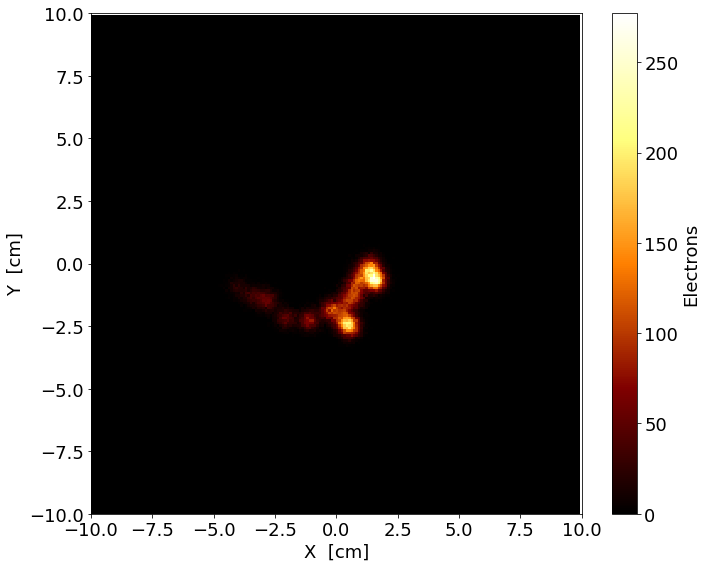

In [21]:
bins = [np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)]
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('afmhot')

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

h1 = ax1.hist2d(Diff_X, Diff_Y, bins=bins, cmap=cmap)

cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
# cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Y  [cm]',fontsize=18)
ax1.set_xlabel(r'X  [cm]',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()